# Análisis de Lesiones Cutáneas para la Detección de Melanoma
## INF395 Introducción a las Redes Neuronales and Deep Learning
- Estudiante: Alessandro Bruno Cintolesi Rodríguez
- ROL: 202173541-0

### 0.- Setup
Importamos ```PyTorch```, seteamos manualmente la ```seed``` en **42** y ajustamos el dispositivo segun la disponibilidad.

In [2]:
# Import torch, NN and functional
import torch
from torch import nn
import torch.nn.functional as F

# Measure time
from timeit import default_timer as timer

# Import sklearn.metric for AUC ROC
from sklearn.metrics import roc_auc_score

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Setup random seed
torch.manual_seed(42)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Implementamos una función para medir el tiempo de entrenamiento de nuestros modelos.

In [3]:
def print_train_time(start: float, end: float, device: torch.device = None):
	"""Prints difference between start and end time.

	Args:
		start (float): Start time of computation (preferred in timeit format).
		end (float): End time of computation.
		device ([type], optional): Device that compute is running on. Defaults to None.

	Returns:
		float: time between start and end in seconds (higher is longer).
	"""
	total_time = end - start
	print(f"Train time on {device}: {total_time:.3f} seconds")
	return total_time

Importamos funciones auxiliares para calcular el ``accuracy_fn()``.

In [4]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
	print("helper_functions.py already exists, skipping download")
else:
	print("Downloading helper_functions.py")
	# Note: you need the "raw" GitHub URL for this to work
	request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
	with open("helper_functions.py", "wb") as f:
		f.write(request.content)

helper_functions.py already exists, skipping download


In [5]:
# Import accuracy metric
from helper_functions import accuracy_fn

Implementamos una función para evaluar el rendimiento de nuestros modelos.

In [6]:
def eval_model(model: torch.nn.Module,
	data_loader: torch.utils.data.DataLoader,
	loss_fn: torch.nn.Module,
	accuracy_fn):
	"""Returns a dictionary containing the results of model predicting on data_loader.

	Args:
		model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
		data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
		loss_fn (torch.nn.Module): The loss function of model.
		accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

	Returns:
		(dict): Results of model making predictions on data_loader.
	"""
	loss, acc = 0, 0
	true_labels = []
	all_probs = []
	
	model.eval()
	with torch.inference_mode():
		for X, y in data_loader:
			# Make predictions with the model
			y_pred = model(X)

			# Accumulate the loss and accuracy values per batch
			loss += loss_fn(y_pred, y).item()
			acc += float(accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)))

			# Probabilities for AUC ROC
			if y_pred.ndim == 2 and y_pred.shape[1] > 1:
				# Multiclass or binary with two outputs
				probs = F.softmax(y_pred, dim=1).detach().cpu()
				all_probs.append(probs)
			else:
				# Binary with one output
				pos_scores = torch.sigmoid(y_pred).detach().cpu().squeeze(1)
				all_probs.append(pos_scores)
			true_labels.append(y.detach().cpu())

	# Scale loss and acc to find the average loss/acc per batch
	loss /= len(data_loader)
	acc = (acc / len(data_loader)) * 100.00

	# Concatenate for sklearn
	y_true = torch.cat(true_labels).numpy()
	prob_blob = torch.cat(all_probs)

	#Calculate ROC-AUC (weighted)
	try:
		if prob_blob.ndim == 2 and prob_blob.shape[1] > 1:
			# Multiclass
			y_prob = prob_blob.numpy()
			roc_auc_weighted = roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")
		else:
			# Binary
			y_score = prob_blob.numpy()
			roc_auc_weighted = roc_auc_score(y_true, y_score)
	except ValueError:
		roc_auc_weighted = float("nan")

	return {
		"model_name": model.__class__.__name__,
		"model_loss": loss.item(),
		"model_acc": acc,
		"roc_auc_weighted": roc_auc_weighted,
	}

Implementamos funciones para simplificar el proceso de entrenamiento y testeo.

In [7]:
def train_step(
	model: torch.nn.Module,
	data_loader: torch.utils.data.DataLoader,
	loss_fn: torch.nn.Module,
	optimizer: torch.optim.Optimizer,
	accuracy_fn,
	device: torch.device = device
):
	train_loss, train_acc = 0, 0
	true_labels, all_probs = [], []

	model.to(device)
	for batch, (X, y) in enumerate(data_loader):
		# Send data to device
		X, y = X.to(device), y.to(device)

		# 1. Forward pass
		y_pred = model(X)

		# 2. Calculate loss
		loss = loss_fn(y_pred, y)
		train_loss += loss
		train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

		# 3. Optimizer zero grad
		optimizer.zero_grad()

		# 4. Loss backward
		loss.backward()

		# 5. Optimizer step
		optimizer.step()

		# Concatenate AUC_ROC labels and probabilities
		with torch.no_grad():
			if y_pred.ndim == 2 and y_pred.shape[1] > 1:
				# Multiclass
				probs = F.softmax(y_pred, dim=1).detach().cpu()
				all_probs.append(probs)
			else:
				# Binary
				pos_scores = torch.sigmoid(y_pred).detach().cpu().squeeze(1)
				all_probs.append(pos_scores)
			true_labels.append(y.detach().cpu())
		
		# Print out how many samples have been seen
		if batch % 8 == 0:
			print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

	# Calculate loss and accuracy per epoch and print out what's happening
	train_loss /= len(data_loader)
	train_acc /= len(data_loader)

	# Calculate AUC_ROC weighted
	try:
		y_true = torch.cat(true_labels).numpy()
		blob   = torch.cat(all_probs)
		if blob.ndim == 2 and blob.shape[1] > 1:
			# Multiclass
			train_auc_weighted = roc_auc_score(y_true, blob.numpy(), multi_class="ovr", average="weighted")
		else:
			# Binary
			train_auc_weighted = roc_auc_score(y_true, blob.numpy())
	except ValueError:
		train_auc_weighted = float("nan")

	print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | ROC-AUC (weighted): {train_auc_weighted:.4f}")

def test_step(
	data_loader: torch.utils.data.DataLoader,
	model: torch.nn.Module,
	loss_fn: torch.nn.Module,
	accuracy_fn,
	device: torch.device = device
):
	test_loss, test_acc = 0, 0
	model.to(device)
	model.eval()

	# AUC_ROC labels and probabilities
	true_labels = []
	all_probs = []

	# Turn on inference context manager
	with torch.inference_mode():
		for X, y in data_loader:
			# Send data to device
			X, y = X.to(device), y.to(device)

			# 1. Forward pass
			test_pred = model(X)

			# 2. Calculate loss and accuracy
			test_loss += loss_fn(test_pred, y).item()
			test_acc += float(accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)))

			# Add probabilities for AUC_ROC
			if test_pred.ndim == 2 and test_pred.shape[1] > 1:
				# Multiclass
				probs = F.softmax(test_pred, dim=1).detach().cpu()
				all_probs.append(probs)
			else:
				# Binary
				pos_scores = torch.sigmoid(test_pred).detach().cpu().squeeze(1)
				all_probs.append(pos_scores)
			true_labels.append(y.detach().cpu())

	# Adjust metrics and print out
	test_loss /= len(data_loader)
	test_acc /= len(data_loader)

	# Calculate AUC_ROC weighted
	try:
		y_true = torch.cat(true_labels).numpy()
		prob_blob = torch.cat(all_probs)

		if prob_blob.ndim == 2 and prob_blob.shape[1] > 1:
			# Multiclass
			y_prob = prob_blob.numpy()
			roc_auc_weighted = roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")
		else:
			# Binary
			y_score = prob_blob.numpy()
			roc_auc_weighted = roc_auc_score(y_true, y_score)
	except ValueError:
		roc_auc_weighted = float("nan")

	print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% | ROC-AUC (weighted): {roc_auc_weighted:.4f}\n")

### 1.- Preparación de los Datos
Primero definimos un ```ìmage_path``` para nuestros datos de entrenamiento, testeo y validacion utilizando ```Path("skin-lesions/")```. Luego implementamos y utilizamos la función ```walk_through_dir(dir_path)``` la cual va printeando por pantalla las distintas subcarpetas y su contenido de forma iterativa.

In [8]:
from pathlib import Path

# Define data directory
image_path = Path("skin-lesions/")
print(f"Image path exists: {image_path.exists()}")

Image path exists: True


In [9]:
import os
def walk_through_dir(dir_path):
	"""
	Walks through dir_path returning its contents.
	Args:
		dir_path (str or pathlib.Path): target directory

	Returns:
		A print out of:
			number of subdiretories in dir_path
			number of images (files) in each subdirectory
			name of each subdirectory
	"""
	for dirpath, dirnames, filenames in os.walk(dir_path):
		print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [10]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'skin-lesions'.
There are 3 directories and 0 images in 'skin-lesions\test'.
There are 0 directories and 117 images in 'skin-lesions\test\melanoma'.
There are 0 directories and 393 images in 'skin-lesions\test\nevus'.
There are 0 directories and 90 images in 'skin-lesions\test\seborrheic_keratosis'.
There are 3 directories and 0 images in 'skin-lesions\train'.
There are 0 directories and 374 images in 'skin-lesions\train\melanoma'.
There are 0 directories and 1372 images in 'skin-lesions\train\nevus'.
There are 0 directories and 254 images in 'skin-lesions\train\seborrheic_keratosis'.
There are 3 directories and 0 images in 'skin-lesions\valid'.
There are 0 directories and 30 images in 'skin-lesions\valid\melanoma'.
There are 0 directories and 78 images in 'skin-lesions\valid\nevus'.
There are 0 directories and 42 images in 'skin-lesions\valid\seborrheic_keratosis'.


Definimos de igual forma ```train_dir```, ```test_dir``` y ```val_dir``` los cuales corresponden a los directorios de cada conjunto correspondiente.

In [11]:
# Define train, test and validation directories
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "valid"

train_dir, test_dir, val_dir

(WindowsPath('skin-lesions/train'),
 WindowsPath('skin-lesions/test'),
 WindowsPath('skin-lesions/valid'))

### 2.- Visualizando una Imagen

A continuación visualizamos una imagen aleatoria a partir del ```image_path_list```. Printemoas por pantalla el **path**, la **clase**, el **tamaño** y el **formato** de la imagen.

In [12]:
import random
from PIL import Image

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Select a random image path
random_image_path = random.choice(image_path_list)

# Get the class name from the image path
class_name = random_image_path.parent.name

# Open the image
img = Image.open(random_image_path)

# Print out some information about the image
print(f"Image path: {random_image_path}")
print(f"Class name: {class_name}")
print(f"Image size: {img.size}")
print(f"Image format: {img.format}")

# Show the image
img.show()

Image path: skin-lesions\train\nevus\ISIC_0014433.jpg
Class name: nevus
Image size: (4288, 2848)
Image format: JPEG


### 3.- Transformando los Datos
Hacemos uso de la libreria ```torchvision``` para transformar nuestras a un **tamaño estandar**, además, realizamos aleatoriamente un **flip horizontal**. Finalmente la imagen es transformada en un ```Tensor```.

In [13]:
# Import necessary libraries for data transformation and loading
from torchvision import transforms
import matplotlib.pyplot as plt

In [35]:
data_transform = transforms.Compose([
	transforms.Resize(size=(227, 227)),
	transforms.TrivialAugmentWide(num_magnitude_bins=31),
	transforms.ToTensor(),
])

Luego visualizamos aleatoriamente ```n``` imagenes a la cuales se les ha aplicado la transformación anteriormente implementada.

In [36]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
	"""Plots a series of random images from image_paths.

	Will open n image paths from image_paths, transform them
	with transform and plot them side by side.

	Args:
		image_paths (list): List of target image paths.
		transform (PyTorch Transforms): Transforms to apply to images.
		n (int, optional): Number of images to plot. Defaults to 3.
		seed (int, optional): Random seed for the random generator. Defaults to 42.
	"""
	random.seed(seed)
	random_image_paths = random.sample(image_paths, k=n)
	for image_path in random_image_paths:
		with Image.open(image_path) as f:
			fig, ax = plt.subplots(1, 2)
			ax[0].imshow(f)
			ax[0].set_title(f"Original \nSize: {f.size}")
			ax[0].axis("off")

			# Transform and plot image
			# Note: permute() will change shape of image to suit matplotlib
			# (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
			transformed_image = transform(f).permute(1, 2, 0)
			ax[1].imshow(transformed_image)
			ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
			ax[1].axis("off")

			fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

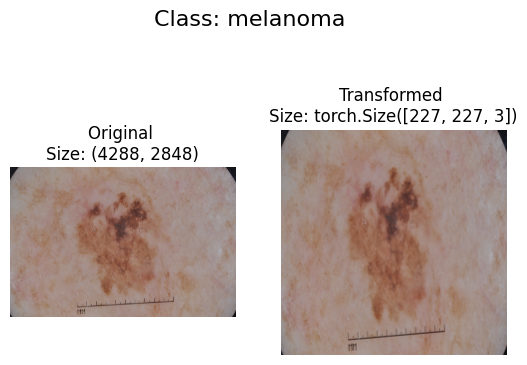

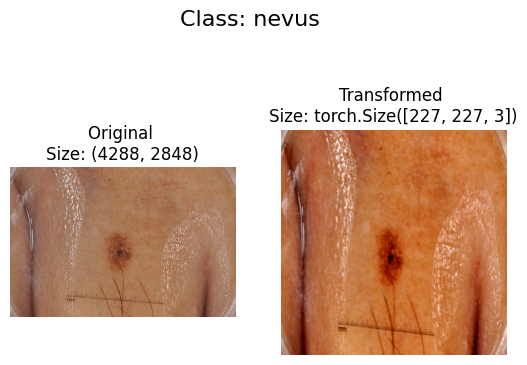

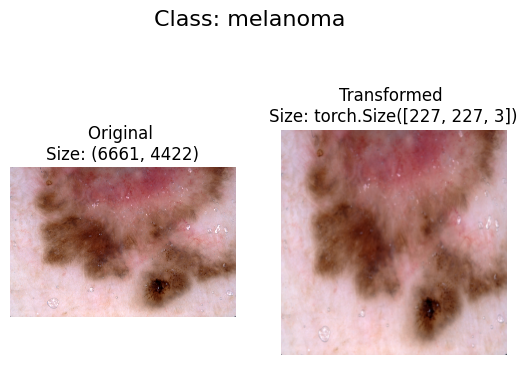

In [37]:
plot_transformed_images(image_path_list, data_transform, n=3, seed=42)

### 4.- Cargando Datos de Imagenes en Datasets
Nuevamente hacemos uso de la libreria ```torchvision``` para transformar nuestras imagenes en ````datasets```, haciendo uso de ```ImageFolder``` y aplicando la transformación **data_transform** antes implementada.

In [38]:
# Import dataset module
from torchvision import datasets

# Create train, test and validation datasets
train_data = datasets.ImageFolder(
	root=train_dir,
	transform=data_transform
)

test_data = datasets.ImageFolder(
	root=test_dir,
	transform=data_transform
)

val_data = datasets.ImageFolder(
	root=val_dir,
	transform=data_transform
)

# Print out some information about the datasets
print(f"- Train data: {train_data}\n\n- Test data: {test_data}\n\n- Validation data: {val_data}")

- Train data: Dataset ImageFolder
    Number of datapoints: 2000
    Root location: skin-lesions\train
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

- Test data: Dataset ImageFolder
    Number of datapoints: 600
    Root location: skin-lesions\test
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

- Validation data: Dataset ImageFolder
    Number of datapoints: 150
    Root location: skin-lesions\valid
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, 

In [39]:
# Print out some information about the datasets
print(f"Number of classes: {len(train_data.classes)}")
print(f"Class names: {train_data.classes}")
print(f"Class dictionary: {train_data.class_to_idx}")
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of validation images: {len(val_data)}")

Number of classes: 3
Class names: ['melanoma', 'nevus', 'seborrheic_keratosis']
Class dictionary: {'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2}
Number of training images: 2000
Number of test images: 600
Number of validation images: 150


In [40]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape} | Image datatype: {img.dtype} | Label: {label} | Label datatype: {type(label)}")
print(f"Image Tensor:\n{img}")

Image shape: torch.Size([3, 227, 227]) | Image datatype: torch.float32 | Label: 0 | Label datatype: <class 'int'>
Image Tensor:
tensor([[[0.0706, 0.0353, 0.0353,  ..., 0.0353, 0.0353, 0.0706],
         [0.0275, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0235],
         [0.0275, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0235],
         ...,
         [0.0275, 0.0118, 0.0078,  ..., 0.0157, 0.0157, 0.0314],
         [0.0275, 0.0118, 0.0078,  ..., 0.0157, 0.0157, 0.0314],
         [0.0784, 0.0392, 0.0392,  ..., 0.0431, 0.0431, 0.0784]],

        [[0.1216, 0.0431, 0.0392,  ..., 0.0392, 0.0392, 0.1176],
         [0.0235, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0235],
         [0.0235, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0235],
         ...,
         [0.0275, 0.0078, 0.0078,  ..., 0.0196, 0.0157, 0.0392],
         [0.0275, 0.0118, 0.0078,  ..., 0.0157, 0.0157, 0.0353],
         [0.1333, 0.0431, 0.0431,  ..., 0.0745, 0.0588, 0.1529]],

        [[0.1216, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.12

### 5.- Visualizar una Imagen de nuestro Dataset
Al visualizar una imagen de nuestro dataset, deberemos aplicar antes una **permutación** debido a que el formato de nuestros datos son el inverso al utilizado por ```matplotlib.pyplot```.

Image shape: torch.Size([3, 227, 227])
Permuted image shape: torch.Size([227, 227, 3])


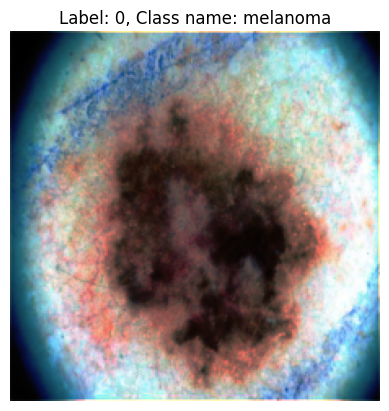

In [41]:
# Change image shape for plotting
img_prmt = img.permute(1, 2, 0)

# Print out image shape and datatype
print(f"Image shape: {img.shape}")
print(f"Permuted image shape: {img_prmt.shape}")

# Plot the image
plt.imshow(img_prmt)
plt.title(f"Label: {label}, Class name: {train_data.classes[label]}")
plt.axis("off")
plt.show()

### 6.- Tranformando datos cargados en DataLoader's
Utilizaremos la función ```DataLoader``` sobre todos nuestros datasets con el objetivo de transformarlos en ```DataLoader's```, esto permite que nuestro modelo sea capaz de iterar sobre los datos, definiendo un **batch_size** (cuantas muestras habran por batch) y un **num_workers** (cuantos subprocesos se encargaran de cargar los datos). Finalmente tenemos la opción de aplicar un ```shuffle``` sobre nuestros datos.

In [42]:
# Import DataLoader
from torch.utils.data import DataLoader

# Create DataLoaders for training, testing, and validation datasets
train_loader = DataLoader(train_data, batch_size=32, num_workers=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, num_workers=1, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, num_workers=1, shuffle=False)

In [43]:
# Get a batch of data
train_features_batch, train_labels_batch = next(iter(train_loader))

# Print out some information about the batch
print(f"Features batch shape: {train_features_batch.shape} | Features datatype: {train_features_batch.dtype}")
print(f"Label batch shape: {train_labels_batch.shape} | Label datatype: {train_labels_batch.dtype}")

Features batch shape: torch.Size([32, 3, 227, 227]) | Features datatype: torch.float32
Label batch shape: torch.Size([32]) | Label datatype: torch.int64


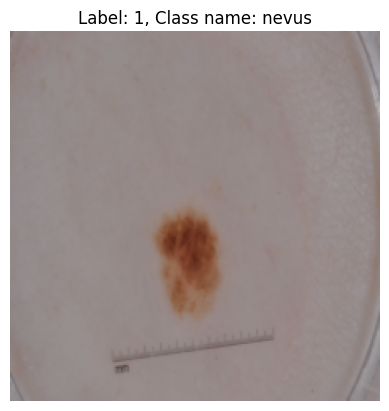

In [44]:
# Pick a random image from the batch
idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[idx], train_labels_batch[idx]

# Change image shape for plotting
img_prmt = img.permute(1, 2, 0)

# Plot a random image from the batch
plt.imshow(img_prmt)
plt.title(f"Label: {label}, Class name: {train_data.classes[label]}")
plt.axis("off")
plt.show()

### 7.- CNN Model
Creamos el modelo para nuestra red neuronal convolucional.

In [45]:
# Create a CNN model with 2 convolutional layers followed by ReLU() and MaxPool2d()
class UltraLightCNN(nn.Module):
	def __init__(self, input_shape: int, hidden_units: int, p_drop: float, num_classes: int):
		super().__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(input_shape, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
			nn.Conv2d(32, 64, 3, 1, 1),   nn.BatchNorm2d(64), nn.ReLU(inplace=True),
			nn.MaxPool2d(2,2),

			nn.Conv2d(64, 96, 3, 1, 1),   nn.BatchNorm2d(96), nn.ReLU(inplace=True),
			nn.Conv2d(96, 128, 3, 1, 1),  nn.BatchNorm2d(128), nn.ReLU(inplace=True),
			nn.MaxPool2d(2,2)
		)
		self.gap = nn.AdaptiveAvgPool2d(1)
		self.head = nn.Sequential(
			nn.Flatten(),
			nn.Dropout(p_drop),
			nn.Linear(128, hidden_units), nn.ReLU(inplace=True),
			nn.Dropout(p_drop),
			nn.Linear(hidden_units, num_classes)
		)

	def forward(self, x):
		x = self.conv(x)
		x = self.gap(x)
		return self.head(x)

In [50]:
# Create a CNN model
class AlexNet(nn.Module):
	def __init__(self, input_shape: int, num_classes: int):
		super().__init__()
		# Convolutional Layer
		self.conv_layer1 = nn.Sequential(
			nn.Conv2d(
				in_channels=input_shape,
				out_channels=96,
				kernel_size=11,
				stride=4,
				padding=2
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=3,
				stride=2,
			),
			nn.ReLU(),
		)

		# Convolutional Layer
		self.conv_layer2 = nn.Sequential(
			nn.Conv2d(
				in_channels=96,
				out_channels=256,
				kernel_size=5,
				stride=1,
				padding=2,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=3,
				stride=2
			),
			nn.ReLU(),
		)

		# Convolutional Layer
		self.conv_layer3 = nn.Sequential(
			nn.Conv2d(
				in_channels=256,
				out_channels=384,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
		)

		# Convolutional Layer
		self.conv_layer4 = nn.Sequential(
			nn.Conv2d(
				in_channels=384,
				out_channels=384,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
		)

		# Convolutional Layer
		self.conv_layer5 = nn.Sequential(
			nn.Conv2d(
				in_channels=384,
				out_channels=256,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=3,
				stride=2
			),
			nn.ReLU(),
		)

		# Classifier Layer
		self.classifier_layer = nn.Sequential(
			nn.Flatten(),
			nn.Dropout(p=0.5),
			nn.Linear(256 * 6 * 6, 4096),
			nn.ReLU(inplace=True),
			nn.Dropout(p=0.5),
			nn.Linear(4096, 4096),
			nn.ReLU(inplace=True),
			nn.Linear(4096, num_classes),
		)

	def forward(self, x):
		x = self.conv_layer1(x)
		x = self.conv_layer2(x)
		x = self.conv_layer3(x)
		x = self.conv_layer4(x)
		x = self.conv_layer5(x)
		x = self.classifier_layer(x)
		return x

In [51]:
# Instantiate our ultra ligth cnn model
alexnet_model = AlexNet(
	input_shape=3,
	num_classes=len(train_data.classes),
)
alexnet_model.to("cpu")

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1,

In [52]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet_model.parameters(), lr=1e-3, weight_decay=1e-2)

In [53]:
train_time_start_on_gpu = timer()

epochs = 2
for epoch in tqdm(range(epochs)):
	print(f"Epoch: {epoch}\n---------")
	train_step(
		data_loader=train_loader,
		model=alexnet_model,
		loss_fn=loss_fn,
		optimizer=optimizer,
		accuracy_fn=accuracy_fn)
	test_step(
		data_loader=test_loader,
		model=alexnet_model,
		loss_fn=loss_fn,
		accuracy_fn=accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(
	start=train_time_start_on_gpu,
	end=train_time_end_on_gpu,
	device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/2000 samples
Looked at 256/2000 samples
Looked at 512/2000 samples
Looked at 768/2000 samples
Looked at 1024/2000 samples
Looked at 1280/2000 samples
Looked at 1536/2000 samples
Looked at 1792/2000 samples
Train loss: 1.08479 | Train accuracy: 68.20% | ROC-AUC (weighted): 0.4849


 50%|█████     | 1/2 [05:01<05:01, 301.10s/it]

Test loss: 0.97421 | Test accuracy: 64.64% | ROC-AUC (weighted): 0.5249

Epoch: 1
---------
Looked at 0/2000 samples
Looked at 256/2000 samples
Looked at 512/2000 samples
Looked at 768/2000 samples
Looked at 1024/2000 samples
Looked at 1280/2000 samples
Looked at 1536/2000 samples
Looked at 1792/2000 samples
Train loss: 0.84176 | Train accuracy: 68.70% | ROC-AUC (weighted): 0.5139


100%|██████████| 2/2 [10:22<00:00, 311.40s/it]

Test loss: 0.91362 | Test accuracy: 64.64% | ROC-AUC (weighted): 0.5964

Train time on cpu: 622.809 seconds


### 8.- Create CSV
Creamos el .csv a partir del conjunto de datos de validacion.

In [55]:
import re
import pandas as pd

_TARGET_LABELS = ["melanoma", "nevus", "seborrheic_keratosis"]

# ---------- Utilidades ----------
def _clean_label(s: str) -> str:
	"""Normaliza etiquetas para comparaciones (lowercase, sin símbolos)."""
	return re.sub(r"[^a-z0-9_]+", "", s.strip().lower().replace(" ", "_").replace("-", "_"))

def _extract_id_from_path(path: str) -> str:
	"""Extrae ID sin extensión: /a/b/ISIC_0001.jpg -> ISIC_0001"""
	return os.path.splitext(os.path.basename(path))[0]

def _prob_reorder_indices(dataset, n_classes):
	"""
	Mapea el orden de salida del modelo al orden requerido por Kaggle.
	Si el dataset tiene class_to_idx => lo detecta y reordena automáticamente.
	"""
	idx_map = list(range(n_classes))  # identidad por defecto
	
	class_to_idx = getattr(dataset, "class_to_idx", None)
	if isinstance(class_to_idx, dict) and len(class_to_idx) == n_classes:
		idx_to_class = {v: k for k, v in class_to_idx.items()}
		derived = []
		for lab in _TARGET_LABELS:
			lab_clean = _clean_label(lab)
			found_idx = None
			for i in range(n_classes):
				ds_lab = _clean_label(str(idx_to_class.get(i, "")))
				if ds_lab == lab_clean:
					found_idx = i
					break
			if found_idx is None:
				return idx_map  # fallback a identidad
			derived.append(found_idx)
		return derived

	return idx_map

def _infer_id_sequence(test_loader):
	"""
	Si el dataset expone rutas (samples/imgs/etc), construye lista de IDs ordenados.
	Esto funciona bien si shuffle=False.
	"""
	ds = getattr(test_loader, "dataset", None)
	for attr in ("samples", "imgs"):  # lista de (path, label)
		if hasattr(ds, attr):
			pairs = getattr(ds, attr)
			return [_extract_id_from_path(p) for p, _ in pairs]
	for attr in ("image_paths", "images", "files", "paths"):
		if hasattr(ds, attr):
			paths = getattr(ds, attr)
			if isinstance(paths, (list, tuple)) and isinstance(paths[0], str):
				return [_extract_id_from_path(p) for p in paths]
	return None

# ---------- Loop sobre test_loader ----------
alexnet_model.eval()
all_rows = []
n_classes = None

global_ids = _infer_id_sequence(test_loader)
global_cursor = 0

with torch.no_grad():
	for batch in test_loader:
		# Detectar forma del batch
		if isinstance(batch, (list, tuple)):
			if len(batch) == 3:
				X, y_or_ids, ids_or_none = batch
				if torch.is_tensor(y_or_ids):
					X, ids = X, ids_or_none  # (img, labels, ids)
				else:
					X, ids = X, y_or_ids  # (img, ids, _)
			elif len(batch) == 2:
				a, b = batch
				if torch.is_tensor(b) and torch.is_tensor(a):
					X, ids = a, None  # (img, labels)
				elif torch.is_tensor(a):
					X, ids = a, b    # (img, ids)
				else:
					X, ids = a, b
			else:
				X, ids = batch, None
		else:
			X, ids = batch, None

		X = X.to(device)
		logits = alexnet_model(X)

		if n_classes is None:
			n_classes = logits.shape[-1]

		probs = torch.softmax(logits, dim=1).cpu().numpy()

		# Resolver IDs
		if ids is not None:
			try:
				batch_ids = [os.path.splitext(os.path.basename(str(i)))[0] for i in ids]
			except Exception:
				batch_ids = [str(i) for i in ids]
		elif global_ids is not None:
			bsz = probs.shape[0]
			batch_ids = global_ids[global_cursor:global_cursor + bsz]
			global_cursor += bsz
		else:
			batch_ids = [f"val_{len(all_rows) + i:06d}" for i in range(probs.shape[0])]

		# Remap clases si es necesario
		idx_map = _prob_reorder_indices(getattr(test_loader, "dataset", None), probs.shape[1])

		for img_id, p in zip(batch_ids, probs):
			p_ordered = [float(p[idx_map[i]]) for i in range(len(_TARGET_LABELS))]
			all_rows.append({
				"Id": img_id,
				"melanoma": p_ordered[0],
				"nevus": p_ordered[1],
				"seborrheic_keratosis": p_ordered[2],
			})

# ---------- Crear CSV ----------
df_sub = pd.DataFrame(all_rows, columns=["Id"] + _TARGET_LABELS)
df_sub["Id"] = df_sub["Id"].astype(str) + ".jpg"
df_sub.to_csv("submission.csv", index=False)
print(f"✅ Archivo generado: submission.csv | Total filas: {len(df_sub)}")
df_sub.head()

✅ Archivo generado: submission.csv | Total filas: 600


,Id,melanoma,nevus,seborrheic_keratosis
0,ISIC_0012258.jpg,0.185309,0.716036,0.098655
1,ISIC_0012356.jpg,0.185177,0.716288,0.098535
2,ISIC_0012369.jpg,0.185303,0.716048,0.098650
3,ISIC_0012395.jpg,0.185310,0.716034,0.098656
4,ISIC_0012425.jpg,0.185349,0.715960,0.098692
